In [1]:
# Celda 0 — Imports, paths y configuración
import os, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Paths estándar del proyecto
SPLITDIR     = "../data/splits"
TRAIN_SPLIT  = f"{SPLITDIR}/train.parquet"
VAL_SPLIT    = f"{SPLITDIR}/val.parquet"
TEST_SPLIT   = f"{SPLITDIR}/test.parquet"

REPORTS_DIR  = "../reports"
BENCH_PATH   = f"{REPORTS_DIR}/automl_bench.csv"              # FLAML ya escribe aquí
PC_METRICS   = f"{REPORTS_DIR}/automl_metrics_by_split.csv"   # PyCaret guardó aquí

# Modelos entrenados
RF_MODEL     = "../models/03D/best_model.pkl"                 # baseline RF (Etapa 3)
PC_MODEL     = "../models/03A_pycaret/pycaret_best_model.pkl" # PyCaret (Etapa 6)
FL_MODEL     = "../models/06_flaml/flaml_automl.pkl"          # FLAML (Etapa 6)

OUT_SELECTION_CSV = f"{REPORTS_DIR}/model_selection.csv"
BEST_JSON         = "../models/best_model.json"

for p in [REPORTS_DIR, os.path.dirname(BEST_JSON)]:
    os.makedirs(p, exist_ok=True)

print("OK — entorno de comparación listo")

OK — entorno de comparación listo


In [2]:
# Celda 1 — Utilidades mínimas (features numéricas) y carga de splits
def make_X_y_numeric(df: pd.DataFrame, y_col: str, id_col: str, ts_col: str):
    y = pd.to_numeric(df[y_col], errors="coerce").astype(float).values
    X = df.drop(columns=[c for c in [y_col, id_col, ts_col] if c in df.columns], errors="ignore")
    X = X.select_dtypes(include=["number"]).fillna(0.0)
    return X, y

Y_COL, ID_COL, TS_COL = "num_bikes_available", "station_id", "ts_local"

df_tr  = pd.read_parquet(TRAIN_SPLIT)
df_val = pd.read_parquet(VAL_SPLIT)
df_te  = pd.read_parquet(TEST_SPLIT) if os.path.exists(TEST_SPLIT) else pd.DataFrame()

Xv_num, yv = make_X_y_numeric(df_val, Y_COL, ID_COL, TS_COL)
Xt_num, yt = (None, None) if df_te.empty else make_X_y_numeric(df_te, Y_COL, ID_COL, TS_COL)

df_tr.shape, df_val.shape, df_te.shape

((152463, 30), (32774, 30), (32712, 30))

In [3]:
# Celda 2 — Cargar benchmark existente y helpers para agregar filas
def empty_bench():
    return pd.DataFrame(columns=[
        "framework","model_path",
        "val_rmse","val_mae","val_r2",
        "test_rmse","test_mae","test_r2"
    ])

bench = pd.read_csv(BENCH_PATH) if os.path.exists(BENCH_PATH) else empty_bench()
bench

,framework,model_path,val_rmse,val_mae,val_r2,test_rmse,test_mae,test_r2
0,flaml,../models/06_flaml/flaml_automl.pkl,0.195527,0.057823,0.998471,0.418451,0.069021,0.993236


In [4]:
# Celda 3 — Asegurar fila de PyCaret (si no está)
def has_framework(df, name): 
    return (len(df[df["framework"]==name])>0) if "framework" in df.columns else False

if not has_framework(bench, "pycaret") and os.path.exists(PC_MODEL) and os.path.exists(PC_METRICS):
    # métricas de PyCaret
    m = pd.read_csv(PC_METRICS)
    row_val = m[(m["framework"]=="pycaret") & (m["split"]=="val")]
    row_tst = m[(m["framework"]=="pycaret") & (m["split"]=="test")] if "split" in m.columns else pd.DataFrame()

    val_rmse = float(row_val["rmse"].iloc[0]) if not row_val.empty else None
    val_mae  = float(row_val["mae"].iloc[0])  if not row_val.empty else None
    val_r2   = float(row_val["r2"].iloc[0])   if not row_val.empty else None

    test_rmse = float(row_tst["rmse"].iloc[0]) if not row_tst.empty else None
    test_mae  = float(row_tst["mae"].iloc[0])  if not row_tst.empty else None
    test_r2   = float(row_tst["r2"].iloc[0])   if not row_tst.empty else None

    bench = pd.concat([bench, pd.DataFrame([{
        "framework":"pycaret", "model_path": PC_MODEL,
        "val_rmse":val_rmse, "val_mae":val_mae, "val_r2":val_r2,
        "test_rmse":test_rmse, "test_mae":test_mae, "test_r2":test_r2
    }])], ignore_index=True)

bench

,framework,model_path,val_rmse,val_mae,val_r2,test_rmse,test_mae,test_r2
0,flaml,../models/06_flaml/flaml_automl.pkl,0.195527,0.057823,0.998471,0.418451,0.069021,0.993236
1,pycaret,../models/03A_pycaret/pycaret_best_model.pkl,0.193582,0.189921,0.998502,0.191583,0.189460,0.998582


In [5]:
# Celda 4 — Asegurar fila de FLAML (si no está ya en automl_bench.csv)
if not has_framework(bench, "flaml") and os.path.exists(FL_MODEL):
    # si por algún motivo no estaba la fila, recomputo rápidamente en val/test
    try:
        from flaml import AutoML
        automl = joblib.load(FL_MODEL)
        yhat_v = np.clip(automl.predict(Xv_num), 0, None)
        rmse = mean_squared_error(yv, yhat_v, squared=False)
        mae  = mean_absolute_error(yv, yhat_v)
        r2   = r2_score(yv, yhat_v)

        t_rmse = t_mae = t_r2 = None
        if Xt_num is not None:
            yhat_t = np.clip(automl.predict(Xt_num), 0, None)
            t_rmse = mean_squared_error(yt, yhat_t, squared=False)
            t_mae  = mean_absolute_error(yt, yhat_t)
            t_r2   = r2_score(yt, yhat_t)

        bench = pd.concat([bench, pd.DataFrame([{
            "framework":"flaml", "model_path": FL_MODEL,
            "val_rmse":rmse, "val_mae":mae, "val_r2":r2,
            "test_rmse":t_rmse, "test_mae":t_mae, "test_r2":t_r2
        }])], ignore_index=True)
    except Exception as e:
        print("FLAML no disponible para evaluación rápida:", e)

bench

,framework,model_path,val_rmse,val_mae,val_r2,test_rmse,test_mae,test_r2
0,flaml,../models/06_flaml/flaml_automl.pkl,0.195527,0.057823,0.998471,0.418451,0.069021,0.993236
1,pycaret,../models/03A_pycaret/pycaret_best_model.pkl,0.193582,0.189921,0.998502,0.191583,0.189460,0.998582


In [6]:
# Celda 5 — Asegurar fila de Baseline RF (si no está)
if not has_framework(bench, "baseline_rf") and os.path.exists(RF_MODEL):
    try:
        rf = joblib.load(RF_MODEL)
        # Para el baseline entrenado en Paso 3, usamos también numéricas y reindex si hiciera falta
        # (si el modelo requiere columnas específicas, toleramos faltantes/orden con reindex)
        try:
            cols = getattr(rf, "feature_names_in_", None)
            Xv_use = Xv_num.reindex(columns=cols, fill_value=0.0) if cols is not None else Xv_num
            Xt_use = None if Xt_num is None else (Xt_num.reindex(columns=cols, fill_value=0.0) if cols is not None else Xt_num)
        except Exception:
            Xv_use, Xt_use = Xv_num, Xt_num

        pred_v = rf.predict(Xv_use)
        rmse = mean_squared_error(yv, pred_v, squared=False)
        mae  = mean_absolute_error(yv, pred_v)
        r2   = r2_score(yv, pred_v)

        t_rmse = t_mae = t_r2 = None
        if Xt_num is not None:
            pred_t = rf.predict(Xt_use)
            t_rmse = mean_squared_error(yt, pred_t, squared=False)
            t_mae  = mean_absolute_error(yt, pred_t)
            t_r2   = r2_score(yt, pred_t)

        bench = pd.concat([bench, pd.DataFrame([{
            "framework":"baseline_rf", "model_path": RF_MODEL,
            "val_rmse":rmse, "val_mae":mae, "val_r2":r2,
            "test_rmse":t_rmse, "test_mae":t_mae, "test_r2":t_r2
        }])], ignore_index=True)
    except Exception as e:
        print("Baseline RF no disponible para evaluación rápida:", e)

bench = bench.reset_index(drop=True)
bench

,framework,model_path,val_rmse,val_mae,val_r2,test_rmse,test_mae,test_r2
0,flaml,../models/06_flaml/flaml_automl.pkl,0.195527,0.057823,0.998471,0.418451,0.069021,0.993236
1,pycaret,../models/03A_pycaret/pycaret_best_model.pkl,0.193582,0.189921,0.998502,0.191583,0.189460,0.998582
2,baseline_rf,../models/03D/best_model.pkl,7.624756,5.755752,-1.324711,7.472862,5.473099,-1.157054


In [7]:
# Celda 6 — Ranking y selección del mejor (reglas: RMSE → MAE → R²)
def rank_bench(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    # invertimos R2 para ordenar ascendente (menor mejor)
    d["_neg_r2"] = -d["val_r2"].fillna(-1e9)
    d["_val_mae"] = d["val_mae"].fillna(np.inf)
    d["_val_rmse"] = d["val_rmse"].fillna(np.inf)
    d = d.sort_values(by=["_val_rmse","_val_mae","_neg_r2"], ascending=[True, True, True])
    d = d.drop(columns=["_neg_r2","_val_mae","_val_rmse"])
    return d

ranked = rank_bench(bench)
ranked

,framework,model_path,val_rmse,val_mae,val_r2,test_rmse,test_mae,test_r2
1,pycaret,../models/03A_pycaret/pycaret_best_model.pkl,0.193582,0.189921,0.998502,0.191583,0.189460,0.998582
0,flaml,../models/06_flaml/flaml_automl.pkl,0.195527,0.057823,0.998471,0.418451,0.069021,0.993236
2,baseline_rf,../models/03D/best_model.pkl,7.624756,5.755752,-1.324711,7.472862,5.473099,-1.157054


In [8]:
# Celda 7 — Guardar resultados y manifiesto del mejor modelo
# Guardar benchmark consolidado
bench.to_csv(BENCH_PATH, index=False)

# Ganador
best_row = ranked.iloc[0].to_dict()
best_row

{'framework': 'pycaret',
 'model_path': '../models/03A_pycaret/pycaret_best_model.pkl',
 'val_rmse': 0.1935816727815198,
 'val_mae': 0.1899206885265688,
 'val_r2': 0.9985015388431678,
 'test_rmse': 0.1915831936634379,
 'test_mae': 0.1894598008724204,
 'test_r2': 0.9985822426030494}

In [9]:
# Guardar selección en CSV y JSON (para predict_batch_autoselect.py)
pd.DataFrame([best_row]).to_csv(OUT_SELECTION_CSV, index=False)

best_manifest = {
    "framework": str(best_row["framework"]),
    "model_path": str(best_row["model_path"]),
    "metric": "rmse",
    "val": {
        "rmse": float(best_row["val_rmse"]) if pd.notnull(best_row["val_rmse"]) else None,
        "mae":  float(best_row["val_mae"])  if pd.notnull(best_row["val_mae"])  else None,
        "r2":   float(best_row["val_r2"])   if pd.notnull(best_row["val_r2"])   else None,
    },
    "test": {
        "rmse": float(best_row["test_rmse"]) if pd.notnull(best_row.get("test_rmse")) else None,
        "mae":  float(best_row["test_mae"])  if pd.notnull(best_row.get("test_mae"))  else None,
        "r2":   float(best_row["test_r2"])   if pd.notnull(best_row.get("test_r2"))   else None,
    }
}
with open(BEST_JSON, "w") as f:
    json.dump(best_manifest, f, indent=2)

print("✅ Guardado:")
print(" - Benchmark:", BENCH_PATH)
print(" - Selección:", OUT_SELECTION_CSV)
print(" - Manifiesto:", BEST_JSON)
best_manifest

✅ Guardado:
 - Benchmark: ../reports/automl_bench.csv
 - Selección: ../reports/model_selection.csv
 - Manifiesto: ../models/best_model.json


{'framework': 'pycaret',
 'model_path': '../models/03A_pycaret/pycaret_best_model.pkl',
 'metric': 'rmse',
 'val': {'rmse': 0.1935816727815198,
  'mae': 0.1899206885265688,
  'r2': 0.9985015388431678},
 'test': {'rmse': 0.1915831936634379,
  'mae': 0.1894598008724204,
  'r2': 0.9985822426030494}}

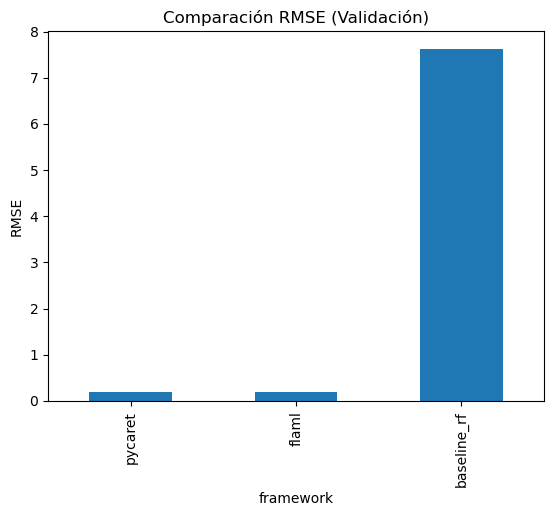

In [10]:
# Celda 8 — Gráfico rápido (RMSE validación)
try:
    ax = bench.set_index("framework")["val_rmse"].sort_values().plot(kind="bar", title="Comparación RMSE (Validación)")
    ax.set_ylabel("RMSE")
except Exception as e:
    print("Plot omitido:", e)

### Celda 9 — Nota final y próximos pasos

Ganador: {best_manifest['framework']}
Modelo:  {best_manifest['model_path']}
VAL:     RMSE={best_manifest['val']['rmse']:.4f} | MAE={best_manifest['val']['mae']:.4f} | R2={best_manifest['val']['r2']:.4f}

Próximo (Etapa 7):
- Registrar en MLflow Model Registry y promover a Staging/Production.
- Usar BEST_JSON desde src/predict_batch_autoselect.py para servir predicciones en el dashboard.

Comandos útiles:
- make mlflow-ui
- make predict_auto  (cuando tengamos el script autoselect)
